c:\Users\LENOVO\Personalized_Healthcare_Recommendations\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data Preview:
    Frequency  Monetary  Time  Class
0         50     12500    99      1
1         13      3250    28      1
2         17      4000    36      1
3         20      5000    45      1
4         24      6000    77      0

Model Evaluation:
MAE: 29.63
MSE: 43546.26
R2 Score: 0.99


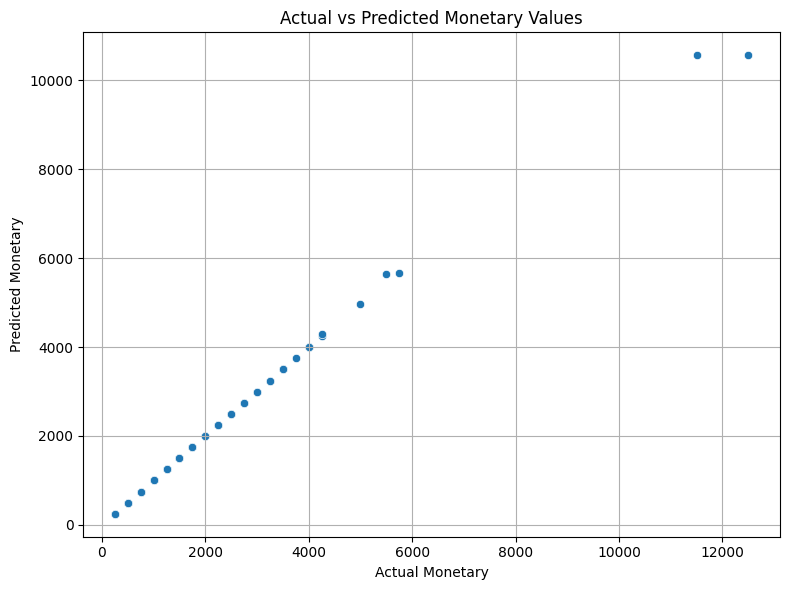


Generating SHAP explainability plot...


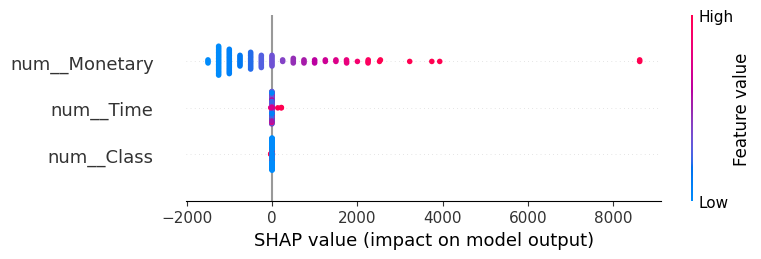

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load data
df = pd.read_csv("../data/cleaned_blood_data.csv")
print("Data Preview:\n", df.head())

# Step 2: Define features and target
X = df.drop('Frequency', axis=1)
y = df['Monetary']

# Step 3: Identify feature types
categorical_features = X.select_dtypes(include='object').columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 4: Handle missing values (optional)
if df.isnull().sum().any():
    df = df.dropna()  # Or replace with imputation

# Step 5: Preprocessing pipelines
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(drop='first'))
])
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_features),
    ('cat', cat_pipeline, categorical_features)
])

# Step 6: Combine with model
model = RandomForestRegressor(random_state=42)
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', model)
])

# Step 7: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Train model
pipeline.fit(X_train, y_train)

# Step 9: Predict and evaluate
y_pred = pipeline.predict(X_test)
print("\nModel Evaluation:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")

# Step 10: Visualize predictions vs actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Monetary")
plt.ylabel("Predicted Monetary")
plt.title("Actual vs Predicted Monetary Values")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 11: Explainability with SHAP
print("\nGenerating SHAP explainability plot...")

# Get transformed features
X_transformed = pipeline.named_steps['preprocessing'].transform(X_test)
feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()

# SHAP requires raw model
explainer = shap.Explainer(pipeline.named_steps['model'], X_transformed)
shap_values = explainer(X_transformed)

shap.summary_plot(shap_values, features=X_transformed, feature_names=feature_names, show=True)
